# Step2 演習02 手書き数字画像を使った多クラス分類
---

本演習では、機械学習界の Hello World 手書き数字の画像データMNISTを利用し、多クラス分類を行うニューラルネットワークのモデルの構築を行います。

画像を使った本格的なニューラルネットワークのモデルの構築に取り組みます。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- 画像データを使ったモデルの学習を行う。
- 手書き数字0から9の10クラスのMNISTのデータセットを利用し、多クラス分類を行う。
- 隠れ層の活性化関数はReLU関数、出力層はソフトマックス関数を使う。
- フォワードプロパゲーションとバックプロパゲーションを実装し、モデルの構築・学習を行う。
- ミニバッチ確率的勾配降下法を実装する。

## ライブラリのインポート

まずはじめに、本演習で利用するライブラリのインポートをします。ライブラリのインポートは一番はじめに行うようにしましょう。

- [NumPy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [Matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番**に順次実行してください。

**注意**： 初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [1]:
# ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## データセットの準備

この演習では "MNIST" と呼ばれる手書き数字のデータを用います。

28ピクセル×28ピクセルのグレースケール画像が学習用データとして55,000枚、テスト用データとして10,000枚含まれています。

今回はTensorFlowで用意されている関数を使ってデータを読み込みます。

read_data_setsの引数は
1. ファイルの保存場所
2. one_hot: one-hotベクトル化するかどうか
3. validation_size: 検証用データの枚数、今回は訓練データとテストデータのみ使用します

使用しているネットワークの強さによりロードに多少時間がかかる場合があります。

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


ダウンロードしたデータセットを訓練データとテストデータとしてそれぞれ定義しておきます。

** 変数名 **
- X_train：訓練データ
- y_train：訓練データの正解ラベル
- X_test：テストデータ
- y_test：テストデータの正解ラベル

In [3]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

print("X_train：訓練データ")
print("y_train：訓練データの正解ラベル")
print("X_test：テストデータ")
print("y_test：テストデータの正解ラベル")

X_train：訓練データ
y_train：訓練データの正解ラベル
X_test：テストデータ
y_test：テストデータの正解ラベル


訓練データとテストデータを確認しましょう。

In [4]:
print("訓練データ数：{}".format(X_train.shape[0]))
print("訓練データ数の特徴：{}".format(X_train.shape[1]))
print("テストデータ数：{}".format(X_test.shape[0]))
print("テストデータ数の特徴：{}".format(X_test.shape[1]))

訓練データ数：55000
訓練データ数の特徴：784
テストデータ数：10000
テストデータ数の特徴：784


"X_train：訓練データ"は、学習用データの55000枚の画像データを行列にしたもの（28×28=784）として格納されています。

同様に、"X_test：テストデータ"は、テスト用データの10000枚の画像データを行列にしたもの（28×28=784）として格納されています。

In [5]:
#訓練データの数をmに格納しておきます。
m = X_train.shape[0]

In [6]:
m

55000

### データセットをシャッフルしよう

MNISTのデータセットをシャッフルします。データセットをそのまま使わずにシャッフルするのはなぜでしょうか。

例えば、データがラベル(y)に対してソートされていたとします。

すると、そのまま冒頭3000サンプルを取って学習に使うと、0, 1と書いてあるデータばかりが集まってしまうことになってしまいます。

一見分からないような規則でソートされている可能性もあるので、データセットの順番がバラバラに見えても必ず最初にシャッフルしてください。

下のセルを実行すると**訓練データ**をランダムな配列にシャッフルしてくれます。

In [7]:
permutation = np.random.permutation(mnist.train.images.shape[0])
X_train = mnist.train.images[permutation]
y_train = mnist.train.labels[permutation]

## データの可視化

配列 X_train には55000枚の画像データ(pixel)が、一列に並んで入っています。X_trainのshapeは(55000, 784)です。

この画像を表示させるには、一列（ベクトル）に並んでしまっている55000枚の画像データをそれぞれ２次元(28, 28)に戻す必要があります。

それにはNumPyの "reshape" を使います。

ここで学習データの画像をランダムに表示させてみます。セルを実行するたびに画像が変わります。

数字：8


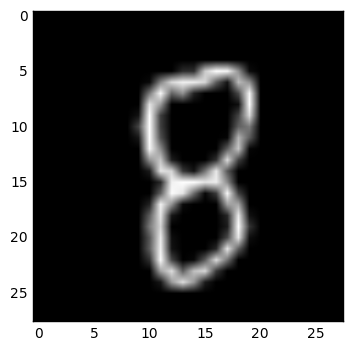

In [8]:
num = np.random.randint(0, len(mnist.train.images))
plt.imshow(mnist.train.images[num].reshape(28, 28), cmap='gray')
print("数字：{}".format(np.argmax(mnist.train.labels[num])))

MNISTの画像一枚が表示されたと思います。さらに、画像に対応する数字が画像の上に表示されていると思います。

次に正解ラベルについて見てみましょう。

正解ラベルの y_train のshapeは(55000,10)です。次のセルのprint文を実行して訓練データとテストデータの正解ラベルを確認します。

In [9]:
print("訓練データの正解ラベル数：{}".format(y_train.shape[0]))
print("訓練データ数の正解ラベルの要素数：{}".format(y_train.shape[1]))
print("テストデータの正解ラベル数：{}".format(y_test.shape[0]))
print("テストデータ数の正解ラベルの要素数：{}".format(y_test.shape[1]))

訓練データの正解ラベル数：55000
訓練データ数の正解ラベルの要素数：10
テストデータの正解ラベル数：10000
テストデータ数の正解ラベルの要素数：10


訓練データの場合、正解ラベル数は55000となっており、それぞれに対して答えとなるラベル部分には「１」が与えられています。

下のセルを実行してください。

In [10]:
y_train[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

例えば、数字の０に対応するラベルは、配列の0番目に１がはいっています。

数字の1に対応するラベルには、配列の1番目に1がはいっています。３以降も同様のルールです。

以下にそれらを可視化してあるので確認してください。
<p>

<div align="center"  style="width:50%">
<img src="./img/step2_mnist_label_019.png"></div>

one-of-k または、one-hotエンコーディングと呼びます。

これまで１つのMNSITのデータをみてきました。少し物足りなさもあるので、MNIST１００個の画像を表示するプログラミムを定義しておきます。

In [11]:
def displayData(images):
    images_reshaped = images.reshape((100, 28, 28))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(images_reshaped[i,:,:])
        plt.axis("off")
        plt.gray()
    plt.show()

実際に表示させてみます。下のセルを実行すると100枚の画像が表示されます。

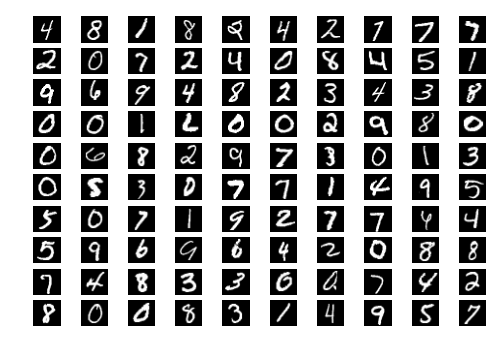

In [12]:
displayData(X_train[:100, :])

## データセットの正規化

ここではデータを整える正規化を行います。データセット全体が平均0.0，分散1.0となるように正規化しましょう。

下のセルを実行してください。

In [13]:
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train-mean) / std
X_test = (X_test-mean) / std

## ニューラルネットワークモデル

これまでは学習に利用するMNISTのデータセットの性質を、訓練データとテストデータに分けてそれぞれ確認してきました。

ここからは今回の演習で用いるニューラルネットワークのモデルを構築します。

入力層のユニット数は特徴の数である784個、出力層は0~9の数字の１０クラス分、隱れ層のユニット数は100個とします。

ここでは下記の条件で、ニューラルネットワークのモデルを構築します：

- 入力層のユニット数784個
- 隠れ層のユニット数100個
- 出力層のユニット数10個

**モデル**:
<div style="width:40%">
<img src="./img/step2_mlp_784-10.png"><div>

### ニューラルネットワークのモデルを定義

**【課題１】** layer_sizes(X, H, Y)を実装してください。戻り値はニューラルネットワークの各層のユニット数 input_size, hidden_size, output_size とします。
 - X：input_size：784ユニット
 - H：hidden_size：100ユニット
 - Y：output_size：10ユニット

In [14]:
#Coursedele-02 Step2 QuestionNumber15 d833ad6615cdf8cfb4de7cc608a32491
def layer_sizes(X, H, Y):
    ###############START CODE HERE###############
    input_size = X
    hidden_size = H
    output_size = Y
    ################END CODE HERE################
    return input_size, hidden_size, output_size

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [15]:
%%bash
./validation_client.py dele-02 2 15 Step2_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [16]:
input_size, hidden_size, output_size = layer_sizes(784, 100, 10)

In [17]:
print("入力層のユニット数：{}".format(input_size))
print("隠れ層のユニット数：{}".format(hidden_size))
print("出力層のユニット数：{}".format(output_size))

入力層のユニット数：784
隠れ層のユニット数：100
出力層のユニット数：10


**Expected Output** .

<table style="width:30%">
  <tr>
    <td>**入力層のユニット数**</td>
    <td> 784 </td> 
  </tr>
  
    <tr>
    <td>**隠れ層のユニット数**</td>
    <td> 100 </td> 
  </tr>
  
    <tr>
    <td>**出力層のユニット数**</td>
    <td> 10 </td> 
  </tr>
  
</table>

## パラメータのランダムに初期化

ニューラルネットワークの学習時に利用するパラメータの重み$w$とバイアス$b$をランダムに初期化します。

パラメータの初期化には、正規分布（ガウス分布）からランダムな値を出力するNumPyの **random.normal** を使用します。

**【課題２】** ランダムにパラメータを初期化する initialize_parameters(input_size, hidden_size, output_size) を実装してください。

戻り値は重み$w_1,w_2$ バイアス$b_1,b_2$とします。

**Note**
- 重みwの初期化：平均0.0，分散0.1で初期化します。random.normalの引数は以下の通り。
 - scale：正規分布の分散 scale=0.1 と記述
 - size：size=(a,b) で行列の形を決める
- バイアスbの初期化：0で定数初期化
 - np.zeros((a, b))
 - numpyのnp.zerosを使います。aとbには数値を与え行列のshapeを決定します。
 
本課題では、行列の形を "input_size, hidden_size, output_size" を使って決定します。

In [18]:
#Coursedele-02 Step2 QuestionNumber16 52a18412afdc58acf6a45e710b0c2eff
def initialize_parameters(input_size, hidden_size, output_size):
    ###############START CODE HERE###############
    W1 = np.random.normal(scale=0.1,size=(input_size,hidden_size))
    b1 = np.zeros((1,hidden_size))
    W2 = np.random.normal(scale=0.1,size=(hidden_size,output_size))
    b2 = np.zeros((1,output_size))
    ################END CODE HERE################
    return W1,b1,W2,b2

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [19]:
%%bash
./validation_client.py dele-02 2 16 Step2_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [20]:
W1,b1,W2,b2 = initialize_parameters(input_size, hidden_size, output_size)

In [21]:
print("W1：" + str(W1.shape))
print("b1：" + str(b1.shape))
print("W2：" + str(W2.shape))
print("b2：" + str(b2.shape))

W1：(784, 100)
b1：(1, 100)
W2：(100, 10)
b2：(1, 10)


**Expected Output**:

<table style="width:25%">
  <tr>
    <td>**W1**</td>
    <td>(784, 100)</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td>(1, 100)</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td>(100, 10)</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td>(1, 10)</td> 
  </tr>
  
</table>


## 活性化関数

隠れ層で使う活性化関数を準備します。今回はReLU関数を実装します。

**【課題３】**  ReLU関数 relu(x) を実装してください。戻り値はReLU関数の出力とします。

ReLU関数：

$$relu(z)=max\{0,z\}$$

In [22]:
#Coursedele-02 Step2 QuestionNumber17 f06a377d24decd89d4a0a6759901af62
def relu(x):
    ###############START CODE HERE###############
    y = np.maximum(0,x)
    ################END CODE HERE################
    return y

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [23]:
%%bash
./validation_client.py dele-02 2 17 Step2_02.ipynb api.internal.zero2one.jp

ExcessiveAccess: Wait for 10 minutes
Error regarding to send score



In [24]:
#ReLU関数の出力
relu(np.array([-5, 0, 1, 5]))

array([0, 0, 1, 5])

**Expected Output**: 
<table style = "width:40%">
    <tr>
    <td>** relu(np.array([-5, 0, 1, 5])) **</td> 
        <td>array([0, 0, 1, 5])</td> 
    </tr>

</table>

** 【課題４】 ** ReLU関数の微分 relu_derivative(x) を実装してください。戻り値はReLU関数の微分の出力とします。

ReLU関数の微分：

$$
  relu\_derivative(z) = \left\{ \begin{array}{ll}
    1　(z>0) \\
    0　(z≦0)
  \end{array} \right.
$$

In [25]:
#Coursedele-02 Step2 QuestionNumber18 0137b6a4cdd565497bb2a7288a93882f
def relu_derivative(x):
    ###############START CODE HERE###############
    x[x > 0] = 1
    x[x <= 0] = 0
    return x
    ################END CODE HERE################

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [26]:
%%bash
./validation_client.py dele-02 2 18 Step2_02.ipynb api.internal.zero2one.jp

ExcessiveAccess: Wait for 10 minutes



In [27]:
#ReLU関数の微分の出力
relu_derivative(np.array([-5, 0, 1, 5]))

array([0, 0, 1, 1])

**Expected Output**: 
<table style = "width:50%">
    <tr>
    <td>** relu_derivative(np.array([-5, 0, 1, 5]))**</td> 
        <td>array([0, 0, 1, 1])</td> 
    </tr>

</table>

ReLUとReLUの微分の結果をそれぞれプロットしてみましょう。

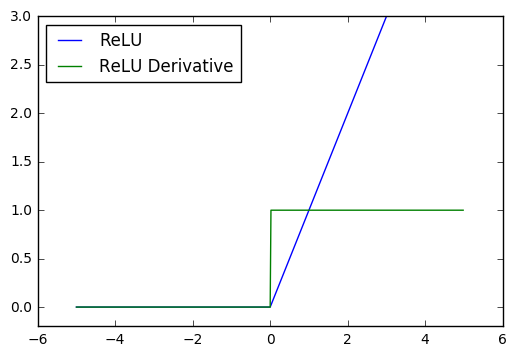

In [28]:
# relu関数
sample_x = np.arange(-5, 5, 0.02) 
y_relu = relu(sample_x)
plt.plot(sample_x, y_relu, label="ReLU") 

# relu関数の微分
sample_x_ = np.arange(-5, 5, 0.02) 
y_derivative = relu_derivative(sample_x)
plt.plot(sample_x_, y_derivative, label="ReLU Derivative") 

plt.ylim(-0.2,3)
plt.legend(loc = 'upper left')
plt.show() 

### ソフトマックス関数

** 【課題5】 **softmax関数の出力を返す関数 softmax(x) を実装してください。

$${\rm softmax}(x)_{i}=\frac{e^{x_i}}{\displaystyle\sum_{j=1}^{n}e^{x_j}}　(i=1,2,\ldots,n)$$

In [29]:
#Coursedele-02 Step2 QuestionNumber19 0baa7f13b6842bda61c92234f678386f
def softmax(x):
    ###############START CODE HERE###############
    c = np.max(x)
    exp_x = np.exp(x-c)
    y = exp_x / np.sum(exp_x,axis=1,keepdims = True)
    ################END CODE HERE################
    return y

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [30]:
%%bash
./validation_client.py dele-02 2 19 Step2_02.ipynb api.internal.zero2one.jp

ExcessiveAccess: Wait for 10 minutes



## フォワードプロパゲーションの実装

さて、これまで

- モデルを定義
- パラメータの初期化
- 活性化関数の実装

以上３つのことを行ってきました。次からは、ニューラルネットワークのモデルの構築を順に進めていきます。

まずは、順伝播、フォワードプロパゲーションの実装をします。

**フォワード**:
$$z^{(1)}=W^{(1)}x^{(1)}+b^{(1)}$$
$$a^{(1)}=relu(z^{(1)})$$
$$z^{(2)}=W^{(2)}a^{(1)}+b^{(2)}$$
$$a^{(2)}=softmax(z^{(2)})$$

**【課題６】** 順伝播を行う関数 forward_propagation(X, W1,b1,W2, b2) を実装してください。戻り値は、各層 $z_1,a_1,z_2,a_2$ の出力とします。

**Note:**
 - フォワードプロパゲーションの実装を行います。layer1_z, layer1_a, layer2_z, layer2_a にそれぞれ記述してください。
 - 上の数式とコードはそれぞれ対応関係にあります。$z^{(1)}$は、"layer1_z"と対応しています。$a^{(1)}$は、"layer1_a"です。以下同様です。
 - 隠れ層の活性化関数にはReLU関数、出力層はソフトマックス関数とします。

In [31]:
#Coursedele-02 Step2 QuestionNumber20 671e4adf82552e2da0a3ead626fc3b9b
def forward_propagation(X, W1,b1,W2, b2):
    ###############START CODE HERE###############
    layer1_z = np.dot(X,W1) + b1
    layer1_a = relu(layer1_z)
    layer2_z = np.dot(layer1_a,W2) + b2
    layer2_a = softmax(layer2_z)
    ################END CODE HERE################
    return layer1_z, layer1_a, layer2_z, layer2_a

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [32]:
%%bash
./validation_client.py dele-02 2 20 Step2_02.ipynb api.internal.zero2one.jp

ExcessiveAccess: Wait for 10 minutes



In [33]:
layer1_z, layer1_a, layer2_z, layer2_a = forward_propagation(X_train, W1,b1,W2, b2)

In [34]:
print("layer1_z：" + str(layer1_z.shape))
print("layer1_a：" + str(layer1_a.shape))
print("layer2_z：" + str(layer2_z.shape))
print("layer2_a：" + str(layer2_a.shape))

layer1_z：(55000, 100)
layer1_a：(55000, 100)
layer2_z：(55000, 10)
layer2_a：(55000, 10)


**Expected Output**:

<table style="width:25%">
  <tr>
    <td>**layer1_z**</td>
    <td>(55000, 100)</td> 
  </tr>
  
  <tr>
    <td>**layer1_a**</td>
    <td>(55000, 100)</td> 
  </tr>
  
  <tr>
    <td>**layer2_z**</td>
    <td>(55000, 10)</td> 
  </tr>
 
  <tr>
    <td>**layer2_a**</td>
    <td>(55000, 10)</td> 
  </tr>
  
</table>

## コスト関数

コスト関数を実装します。

**コスト関数**：
$$C(w,b)=-\frac{1}{m}\sum_{n=1}^{m}y_n{\log}\hat{y}_{n}$$

**【課題７】** 目的関数の値を計算する関数compute_cost(y, y_hat, m)を実装してください。戻り値は、コスト関数の出力とします。

**Note:**
 - クロスエントロピーをコスト関数とします。
 - フォワードプロパーゲションの出力は、layer2_a です。$\hat{y}$に対応します。
 - $y$ は正解ラベル
 - $\hat{y}$ はモデルの出力
 - $m$ は訓練データ数

In [35]:
#Coursedele-02 Step2 QuestionNumber21 527b20d1e29b964ef618580303d00ab6
def compute_cost(y, y_hat, m):
    ###############START CODE HERE###############
    cost = - np.sum(y * np.log(y_hat)) / m   
    ################END CODE HERE################
    return cost

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [36]:
%%bash
./validation_client.py dele-02 2 21 Step2_02.ipynb api.internal.zero2one.jp

ExcessiveAccess: Wait for 10 minutes



In [37]:
cost = compute_cost(y_train, layer2_a, m)

In [38]:
print("初期のパラメータのモデルのコスト: ", cost)

初期のパラメータのモデルのコスト:  3.985370522488521


このコスト関数の出力をゼロに近づけることがモデルの学習の一つの目標でもあります。

## バックプロパゲーションの実装

逆伝播（バックプロパゲーション）では、目的関数のパラメータについての勾配を求めます。

**バックプロパゲーション**:
<br>

<div style="width:70%">
<img src="./img/NN_fp_bp_ce_softmax.png"></div>
<br>
<br>
※このイメージは、コスト関数にクロスエントロピー、出力層にはソフトマックス関数を用いた例です。

**【課題８】** 逆伝播を行う関数 back_propagation(X, y, W2, layer1_z, layer1_a, layer2_z, layer2_a) を実装してください。

戻り値は、目的関数のパラメータに関する勾配 $w_1,b_1,w_2,b_2$ とします。

**Note1:**
 - 上の数式を参考にバックプロパゲーションを実装を行います。
 - バックプロパゲーションはディープラーニングで一番大変な部分ですが、ここ乗り越えることは非常に重要な意味を持ちますので頑張りましょう。
 - 行列演算に注意し、np.dot()や転置行列を意味する".T"を使用することでうまく実装します。
 
**Note2:**
 
 * X：入力データ
 * y：正解ラベル
 * W2：隠れ層と出力層の間の重み
 * layer1_z：レイヤー1の線形結合$z_1$
 * layer1_a：レイヤー1の活性化後の値$a_1$
 * layer2_z：レイヤー2の線形結合$z_2$
 * layer2_a：レイヤー2の出力の値$a_2$
 * relu_derivative()：ReLU関数の微分

In [39]:
#Coursedele-02 Step2 QuestionNumber22 28294163521b1c269719b8b6ca85ec6c
def backward_propagation(X, y, W2, layer1_z, layer1_a, layer2_z, layer2_a, batch_size):
    ###############START CODE HERE###############
    derivative_layer2_z = (layer2_a - y)/batch_size
    delta_W2 = np.dot(layer1_a.T,derivative_layer2_z)
    delta_b2 = np.sum(derivative_layer2_z, axis=0 ,keepdims=True) 
        
    derivative_layer1_z = np.dot(derivative_layer2_z,W2.T) * relu_derivative(layer1_z)
    delta_W1 = np.dot(X.T,derivative_layer1_z)
    delta_b1 = np.sum(derivative_layer1_z,axis=0,keepdims=True)
    ################END CODE HERE################
    return delta_W2, delta_b2, delta_W1, delta_b1

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [40]:
%%bash
./validation_client.py dele-02 2 22 Step2_02.ipynb api.internal.zero2one.jp

ExcessiveAccess: Wait for 10 minutes



In [41]:
delta_W2, delta_b2, delta_W1, delta_b1 = backward_propagation(X_train, y_train, W2, layer1_z, layer1_a, layer2_z, layer2_a, batch_size=100)

In [42]:
print ("delta_W1："+ str(delta_W1.shape))
print ("delta_b1："+ str(delta_b1.shape))
print ("delta_W2："+ str(delta_W2.shape))
print ("delta_b2："+ str(delta_b2.shape))

delta_W1：(784, 100)
delta_b1：(1, 100)
delta_W2：(100, 10)
delta_b2：(1, 10)


**Expected Output**:

<table style="width:25%">
  <tr>
    <td>**delta_W1**</td>
    <td>(784, 100)</td> 
  </tr>
  
  <tr>
    <td>**delta_b1**</td>
    <td>(1, 100)</td> 
  </tr>
  
  <tr>
    <td>**delta_W2**</td>
    <td>(100, 10)</td> 
  </tr>
 
  <tr>
    <td>**delta_b2**</td>
    <td>(1, 3)</td> 
  </tr>
  
</table>

## パラメータの更新

パラメータの更新です。

*パラメータの更新式：*
$$w=w-\alpha\Delta{w}$$
$$b=b-\alpha\Delta{b}$$

In [43]:
#学習率を定義します。
learning_rate = 0.01

**【課題９】** パラメータの更新を行う update_parameters(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate) を実装してください。

戻り値は、パラメータ $W_1,b_1,W_2,b_2$ とします。

**Note:**
 - バックプロパゲーションで計算した勾配を用いてパラメータの更新を行います。
 - $\alpha$は学習率（learning_rate）です。

In [44]:
#Coursedele-02 Step2 QuestionNumber23 82717d28b5f91771a87ae5eac2166775
def update_parameters(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate):
    ###############START CODE HERE###############
    W1 = W1 - learning_rate * delta_W1
    b1 = b1 - learning_rate * delta_b1
    W2 = W2 - learning_rate * delta_W2
    b2 = b2 - learning_rate * delta_b2
    ################END CODE HERE################
    return W1, b1, W2, b2

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [45]:
%%bash
./validation_client.py dele-02 2 23 Step2_02.ipynb api.internal.zero2one.jp

ExcessiveAccess: Wait for 10 minutes



In [46]:
W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate)

In [47]:
print("W1：" + str(W1.shape))
print("b1：" + str(b1.shape))
print("W2：" + str(W2.shape))
print("b2：" + str(b2.shape))

W1：(784, 100)
b1：(1, 100)
W2：(100, 10)
b2：(1, 10)


### 正解率を計算する関数を用意

正解率を計算する関数accuracy(y, y_hat)を実装しておきます。このまま実行してください。

- $y$ は正解ラベル
- $\hat{y}$ はモデルの出力

In [48]:
def accuracy(y, y_hat):
    accuracy = (np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))
    accuracy = accuracy.mean()
    return accuracy

## ミニバッチ確率的勾配降下法を体験しよう

ミニバッチ確率的勾配降下法とは、訓練データをいくつかの小さいグループに分けて、グループ単位で繰り返し学習を行う手法です。

例えば、１から１５の数字の配列があったとします。下のセルを実行してください。

In [49]:
data_set = np.arange(1,16,1)
print(data_set)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


全部で１５個の数字を先頭から3つのグループにわけ、１つのグループあたり５個のデータとします。

- 全データ数１５
- グループあたりのデータ数：５

In [50]:
sample_size = 15
batch_size = 5

このときのグループ単位でニューラルネットワークのモデルの学習を実行したいと考えた場合下記のようなコードを書くことができます。

In [51]:
for i in range(0, sample_size, batch_size):
    print(data_set[i:i+batch_size])

[1 2 3 4 5]
[ 6  7  8  9 10]
[11 12 13 14 15]


一つ目のグループは１から５のデータが、二つ目のグループは６から１０のデータが、三つ目のグループは１１から１５のデータが、、

といったように全データをいくつかのグループにわけて実行しています。

またニューラルネットワークの学習では一般的に用意した訓練データを用いて繰り返しモデルの学習を行うため、繰り返し回数であるエポックを決める必要があります。

In [52]:
epochs = 3 #ここではエポックを３と定義

下のセルを実行して同じデータを使って繰り返しデータを使うイメージを掴みましょう。

In [53]:
for _ in range(epochs):
    print(_ + 1, "回目の学習")
    for i in range(0, sample_size, batch_size):
        print(data_set[i:i+batch_size])

1 回目の学習
[1 2 3 4 5]
[ 6  7  8  9 10]
[11 12 13 14 15]
2 回目の学習
[1 2 3 4 5]
[ 6  7  8  9 10]
[11 12 13 14 15]
3 回目の学習
[1 2 3 4 5]
[ 6  7  8  9 10]
[11 12 13 14 15]


## ニューラルネットワークモデルの実装

最後にニューラルネットワークのモデルを構築します。

これまで学習してきたコードを参考に、それぞれ"None"となっている部分に書き込みましょう。

本演習のニューラルネットワークのモデルでは、ミニバッチ確率的勾配降下法を実装しモデルの学習に取り組みます。

<br>

<div style="width:50%">
<img src="./img/nn_learn_cycle.png"></div>

**【課題１０】** ニューラルネットワークのモデル nn_model()を実装してください。

**Note１:**
 - これまで学習してきたコードを使って、ニューラルネットワーク全体のモデルを実装します。
 - 1回目のfor文でエポック（epochs）がエポック処理を行う。
 - 2回目のfor文でミニバッチ（batch_size）を行う。

**Note２:**

関数 nn_model()に渡す引数は次の通りです。
 
* X：訓練データ
* y：訓練データの正解ラベル
* X_test：テストデータ
* y_test：テストデータの正解ラベル
* input_size：入力層のユニット数
* hidden_size：隠れ層のユニット数
* output_size：出力層のユニット数
* epochs：エポック
* sample_size：全てのデータの数
* batch_size：ミニバッチ学習のデータ数
* learning_rate：学習率

In [54]:
# ニューラルネットワークのモデルを構築
def nn_model(X, y, X_test,y_test, input_size, hidden_size, output_size, epochs, sample_size, batch_size, learning_rate,  print_cost=False):

    # コスト/精度を記録するための配列
    train_Data_cost = []
    train_Data_acc = []
    test_Data_cost = []
    test_Data_acc = []
    
    #エポックのカウントとパラメータを初期化
    count = 0    
    W1,b1,W2,b2 = initialize_parameters(input_size, hidden_size, output_size)
     
    #エポック
    for _ in range(epochs):
        #ミニバッチ
        for i in range(0, sample_size, batch_size):
            
             #########################START CODE HERE#########################
            #ミニバッチ処理
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
        
            #フォワードプロパゲーション
            layer1_z, layer1_a, layer2_z, layer2_a = forward_propagation(X_batch, W1,b1,W2, b2)
            
            #バックプロパゲーション
            delta_W2, delta_b2, delta_W1, delta_b1 = backward_propagation(X_batch, y_batch, W2, layer1_z, layer1_a, layer2_z, layer2_a, batch_size)
            
            #パラメータの更新
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate)
            ##########################END CODE HERE##########################

        #訓練データのエポックごとのコスト値
        train_output = forward_propagation(X, W1,b1,W2, b2)
        train_cost = compute_cost(y, train_output[3], sample_size)
        train_Data_cost.append(train_cost)
        
        #訓練データのエポックごとの精度
        train_acc = accuracy(y, train_output[3])
        train_Data_acc.append(train_acc)
        
        #テストデータのエポックごとのコスト値
        test_output = forward_propagation(X_test, W1,b1,W2, b2)
        test_cost = compute_cost(y_test, test_output[3], y_test.shape[0])
        test_Data_cost.append(test_cost)
        
        #テストデータのエポックごとの精度
        test_acc = accuracy(y_test, test_output[3])
        test_Data_acc.append(test_acc)

        #エポック数をカウント
        count += 1
        print('epochs：{0:.0f}'.format(int(count)), 'train cost：{0:.2f}'.format(train_cost),'train acc：{0:.2f}%'.format(train_acc*100))
    
    print("Leaning Done!!")
    
    return train_Data_cost, train_Data_acc, test_Data_cost, test_Data_acc, W1, b1, W2, b2

nn_model()に各パラメータを与え、学習を実行させます。ここではひとまず以下のとおりパラメータを設定します。
- input_size = 784
- hidden_size = 100
- output_size = 10
- epochs = 10
- sample_size = 55000
- batch_size = 55000
- learning_rate = 0.01

**パラメータの指定**

In [79]:
#パラメータの指定
input_size = 784
hidden_size = 100
output_size = 10
epochs = 10
sample_size = 55000
batch_size = 100
learning_rate = 0.1

以下のセルを実行するとモデルの学習がはじまります。

In [80]:
train_Data_cost, train_Data_acc, test_Data_cost, test_Data_acc, W1, b1, W2, b2 = \
nn_model(X_train, y_train, X_test, y_test, input_size, hidden_size, output_size, epochs, sample_size, batch_size, learning_rate, print_cost=True)

epochs：1 train cost：0.18 train acc：94.42%
epochs：2 train cost：0.13 train acc：96.09%
epochs：3 train cost：0.10 train acc：96.91%
epochs：4 train cost：0.08 train acc：97.47%
epochs：5 train cost：0.07 train acc：97.89%
epochs：6 train cost：0.06 train acc：98.22%
epochs：7 train cost：0.05 train acc：98.50%
epochs：8 train cost：0.05 train acc：98.70%
epochs：9 train cost：0.04 train acc：98.87%
epochs：10 train cost：0.04 train acc：99.03%
Leaning Done!!


本演習で用意した**テストデータにおける正解率が95%以上**でクリアとなります。

テストデータの正解率を確かめるには下のセルを実行してください。

In [81]:
output = forward_propagation(X_test, W1, b1, W2, b2)
acc = accuracy(y_test, output[3])
print("テストデータの正解率は{}%".format(acc*100))

テストデータの正解率は97.21%


もしテストデータにおける正解率が95%に届いていない場合、パラメータを少し変更してみましょう。

今回はバッチサイズ（batch_size）を55000で学習を進めてみました。

一回の学習ですべての訓練データを使ったことになり、合計で１０回（エポック数）しかパラメータを更新したことになりません。

もしかするとあまりいい学習結果を得ることができていないと思います。

そこでバッチサイズを **100**に変えて改めて学習を進めてみてください。

---

１度のエポックで55回パラメータを更新したことになり、パラメータを何度も更新した結果かなり精度が高くなったと思います。

ただしもっと精度を改善できそうです。

---

では最後に、学習率 **0.01** を **0.1** に変更した上で、改めて学習をスタートしてください。

正解率が95%に届いていたら、学習後のパラメータを採点用に保存します。下のセルをそのまま実行してください。

In [82]:
#パラメータを保存
import h5py
with h5py.File('./learned_parameter/mnist_parameter_learned.h5', 'w') as f:
    f.create_dataset('W1', data=W1)
    f.create_dataset('b1', data=b1)
    f.create_dataset('W2', data=W2)
    f.create_dataset('b2', data=b2) 

下のセルで課題１０のニューラルネットワークモデルの採点関数を実行します。

In [83]:
#Coursedele-02 Step2 QuestionNumber24 d5f1815725c80cabfb652892b1aa1692
def nn_model_mnist():
    return

**ファイルを保存後**、次のセルを実行（Shift+Enter）で採点を行います。

In [84]:
%%bash
./validation_client.py dele-02 2 24 Step2_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## コスト減少のグラフ

訓練データとテストデータにおけるコスト関数の出力が最適化されてコストが減少していく様子をプロットする。

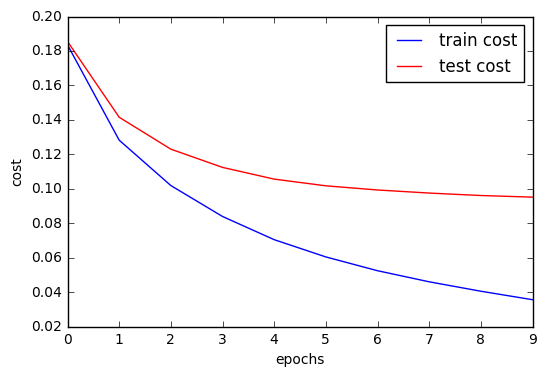

In [85]:
plt.plot(train_Data_cost, c='b', label='train cost')
plt.plot(test_Data_cost, c='r', label='test cost')
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()
plt.show()

## 学習精度のグラフ

エポックごとに学習精度が向上していく様子をプロットする。

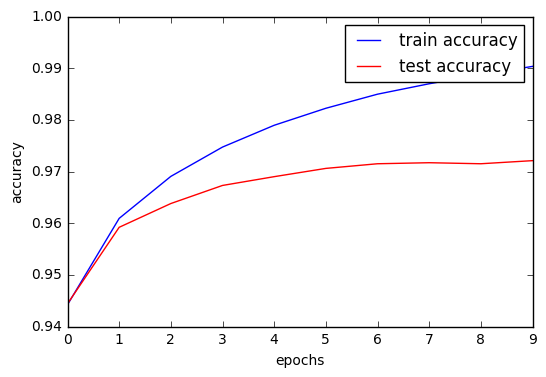

In [86]:
plt.plot(train_Data_acc, c='b', label='train accuracy')
plt.plot(test_Data_acc, c='r', label='test accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

データをグラフにすることで次の改善点の示唆を学習結果から得ることができます。データは必ず可視化するようにしましょう。

## 実際に予測してみる

最後に学習後のパラメータをモデルを使って、訓練データの精度を確認してみましょう。

In [87]:
hidden1 = np.dot(X_train, W1) + b1
act1 = relu(hidden1)
hidden2 = np.dot(act1, W2) + b2
act2 = softmax(hidden2)
predicted_class = np.argmax(act2, axis=1)
predicted_class_y_train = np.argmax(y_train,axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == predicted_class_y_train)))

training accuracy: 0.99


次に、テストデータを使ってモデルの精度を確認してみましょう。

In [88]:
hidden1 = np.dot(X_test, W1) + b1
act1 = relu(hidden1)
hidden2 = np.dot(act1, W2) + b2
act2 = softmax(hidden2)
predicted_class = np.argmax(act2, axis=1)
predicted_class_y_test = np.argmax(y_test,axis=1)
print ('test accuracy: %.2f' % (np.mean(predicted_class == predicted_class_y_test)))

test accuracy: 0.97


訓練データとテストデータの精度を比較するとどちらも大差はあまりみられなかったと思います。

汎化性能は高く良いモデルを構築することができたと考えることができそうです。

## おつかれさまでした。

Great Job!!

以上で手書き数字の画像を分類するニューラルネットワークの実装はおしまいです。

これまでのレッスンを完璧にマスターすることができていれば、ニューラルネットワークの基礎は抑えることができています。

お気付きの方もいらっしゃると思いますが、これまでの演習を通してXORのデータからMNISTの画像のデータを扱いました。

基本的なモデルの実装方法にあまり違いはなかったと思います。

違ったのは１桁のデータセット数から万単位のデータセット数といったデータの変化による、ニューラルネットワークのモデルの構造のみです。

また、演習では課題以外にも様々なコードを実行していただきました。

どれも有用なコードになっていると思いますので、きちんと使えるようになっておいてください。